In [1]:
import torch as pt
import torchvision as tv
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from GeneticSolver import *

In [37]:
data = np.load('full_mnist.npz')
X, y = data['X'], data['y']
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, test_size=.2, random_state=42)

In [38]:
image_size = X[0].shape

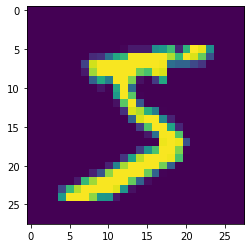

In [39]:
plt.imshow(X[0]);

In [40]:
class CNN(pt.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = pt.nn.Sequential(
        pt.nn.Conv2d(1, 30, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Conv2d(30, 30, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Conv2d(30, 15, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Flatten(),
        pt.nn.Linear(15, 64),
        pt.nn.ReLU(),
        pt.nn.Linear(64, 10),
        pt.nn.Softmax(dim=1)
        )
    
    def predict(self, X):
        return self.model(X)


model = CNN()
optim = pt.optim.Adam(model.parameters())
loss = pt.nn.CrossEntropyLoss()

In [41]:
X_train = pt.Tensor(X_train).unsqueeze(1)
y_train = pt.Tensor(y_train).long()
X_test = pt.Tensor(X_test).unsqueeze(1)
y_test = pt.Tensor(y_test).long()
train_loader = pt.utils.data.DataLoader(pt.utils.data.TensorDataset(X_train, y_train), batch_size=32)
test_loader = pt.utils.data.DataLoader(pt.utils.data.TensorDataset(X_test, y_test), batch_size=32)

In [42]:
epochs = 1
pt.manual_seed(42)
for epoch in range(epochs):
    for Xt, yt in tqdm.tqdm(train_loader):
        optim.zero_grad()
        yp = model.predict(Xt)
        L = loss(yp, yt)
        L.backward()
        optim.step()
    
    with pt.no_grad():
        predictions = []
        for Xt, yt in tqdm.tqdm(test_loader):
            y_pred = model.predict(Xt)
            predictions.append(y_pred.argmax(axis=1))
        test_predictions = pt.cat(predictions)
        accuracy = (test_predictions == y_test).sum().float() / len(y_test)
        print(f'val acc = {accuracy}')
    

100%|██████████| 375/375 [00:02<00:00, 164.12it/s]

val acc = 0.8229166865348816


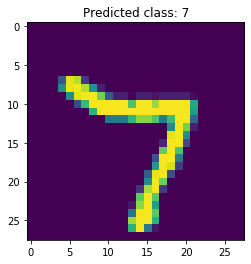

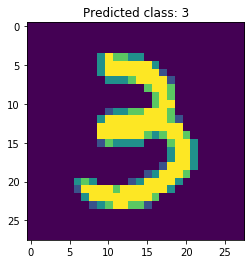

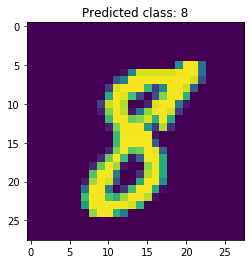

In [43]:
top_n = 3
first_n_pred = model.predict(X_test[:top_n]).argmax(axis=1)
for i in range(top_n):
    x = X_test[i].squeeze()
    plt.imshow(x)
    plt.title(f'Predicted class: {first_n_pred[i]}');
    plt.show()

In [97]:
adv_target = 0

In [98]:
def fitness_class_probability(X):
    """ Maximize probability of adversarial target class"""
    y = model.predict(pt.Tensor(X).unsqueeze(1)).detach().numpy()
    y_mean = y[:, adv_target]
    return y_mean

In [99]:
m = GeneticSolver(image_size=image_size, verbosity=True, warm_start=True)

In [100]:
res, score = m.solve(fitness_class_probability, n_generations=1000, verbose_step=250)

Generation #: best score
Early stopping on generation  127  with best score  0.9999937


In [101]:
def visualize(adversary_example, adversary_score):
    y_pred = model.predict(pt.Tensor(adversary_example).unsqueeze(0).unsqueeze(1))
    assert np.isclose(y_pred.sum().item(), 1)
    target_prob = y_pred[0][adv_target].item()
    plt.figure(figsize=(6, 6))
    plt.imshow(adversary_example, cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.title(f"P(X={adv_target})={target_prob:.4f}|Fitness={adversary_score:.4f}");

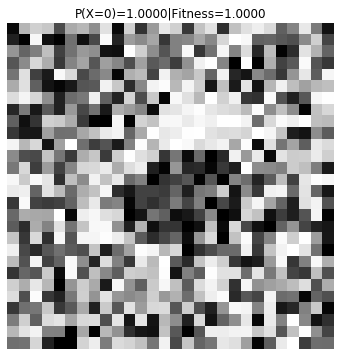

In [102]:
visualize(res, score)

In [111]:
def fitness_class_probability_empty(X):
    """ Maximize probability of adversarial target class, penalizing mean pixel intensity"""
    y = model.predict(pt.Tensor(X).unsqueeze(1)).detach().numpy()
    y_target = y[:, adv_target]
    X_mean = X.mean(axis=1).mean(axis=1)
    return y_target - X_mean

In [115]:
m = GeneticSolver(image_size=image_size, verbosity=True, verbosity_step=100, warm_start=True, patience=200)
res, score = m.solve(fitness_class_probability_empty, n_generations=5000, verbose_step=500)

Generation #: best score
Generation  500 :  0.7664117446091117
Generation  1000 :  0.8526554294640023
Generation  1500 :  0.8899553743586278
Generation  2000 :  0.8994700041498872
Generation  2500 :  0.9108933366718494
Generation  3000 :  0.9187642786479883
Generation  3500 :  0.9217812693428462
Early stopping on generation  3643  with best score  0.9217812693428462


In [116]:
res.mean()

0.07682815429454398

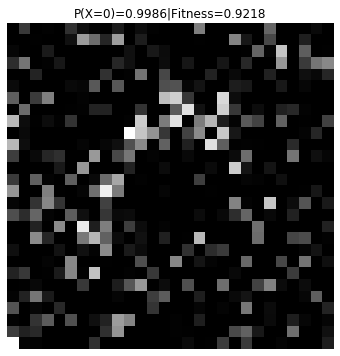

In [117]:
visualize(res, score)

Generation #: best score
Generation  700 :  0.8100469314450032
Generation  1400 :  0.8767762963227459
Generation  2100 :  0.9019891509684078
Generation  2800 :  0.9116790787245544
Generation  3500 :  0.9183711626685269
Generation  4200 :  0.9232360799480105
Generation  4900 :  0.9259910948011922
Generation  5600 :  0.928072632081943
Generation  6300 :  0.929520465703687
Generation  6999 :  0.932954514417909


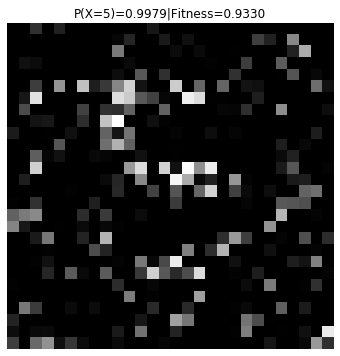

In [119]:
adv_target = 5
m = GeneticSolver(image_size=image_size, verbosity=True, verbosity_step=100, warm_start=True, random_state=42, early_stopping=False)
res, score = m.solve(fitness_class_probability_empty, n_generations=7000, verbose_step=700)
visualize(res, score)

In [164]:
def fitness_similarity(X):
    """ X - np.array"""
    y = model.predict(pt.Tensor(X).unsqueeze(1)).detach().numpy()
    y_target = y[:, adv_target]
#     mae = np.abs(X - adv_sample).mean(axis=1).mean(axis=1)
    mse = np.power(X - adv_sample, 2).mean(axis=1).mean(axis=1) ** .5
    return y_target - mse

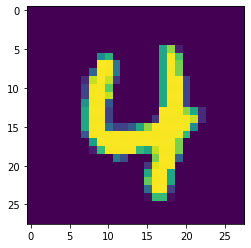

In [169]:
adv_sample = X_test[9].numpy()
plt.imshow(adv_sample.squeeze());

Generation #: best score
Generation  800 :  0.847113211167583
Generation  1600 :  0.8701224157735055
Generation  2400 :  0.8742161694304544
Generation  3200 :  0.8779726747069615
Generation  4000 :  0.8797027943944221
Generation  4800 :  0.8809138632435551
Generation  4999 :  0.8809138632435551


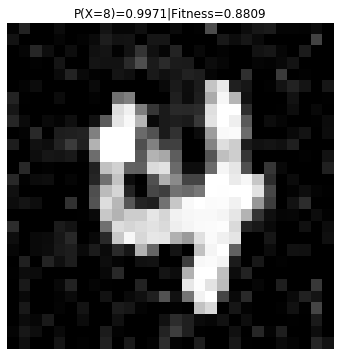

In [171]:
adv_target = 8
m = GeneticSolver(image_size=image_size, population_size=300, verbosity=True, verbosity_step=100, warm_start=True, random_state=42, early_stopping=False)
res, score = m.solve(fitness_similarity, n_generations=5000, verbose_step=800)
visualize(res, score)